### Why ResNet?
ResNet was selected because its residual connections help the network learn deeper and more detailed representations without gradient issues. This allows the model to capture subtle waveform patterns more effectively and makes it a strong architecture to compare against EfficientNet-B0 in our evaluation.

In [1]:
%%capture
%run pre_processing2.ipynb

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: initialization failed

ImportError: initialization failed

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

 Dataset Class

In [59]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class WaveformDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join("newDataset_images", row['image_name'])
        label    = row['label_id']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


 DataLoaders

In [60]:
BATCH_SIZE = 16

train_dataset = WaveformDataset(train_df, transform=train_transform)
val_dataset   = WaveformDataset(val_df,   transform=val_test_transform)
test_dataset  = WaveformDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("Loaders ready.")


Loaders ready.


Load ResNet18 pretrained

In [61]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(cropped_df['label_id'].unique())

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# تعديل آخر طبقة
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("Model loaded on:", device)


Model loaded on: cpu


Loss + Optimizer + Class Weights

In [62]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Training Loop

In [63]:
EPOCHS = 15

best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # ===== Validation =====
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18.pth")
        print("Saved new BEST model!")

print("Training Complete.")


Epoch 1/15 | Train Loss: 0.8513, Train Acc: 0.7329 | Val Loss: 0.3684, Val Acc: 0.8933
Saved new BEST model!
Epoch 2/15 | Train Loss: 0.3153, Train Acc: 0.9017 | Val Loss: 0.2931, Val Acc: 0.9083
Saved new BEST model!
Epoch 3/15 | Train Loss: 0.1896, Train Acc: 0.9472 | Val Loss: 0.2542, Val Acc: 0.9220
Saved new BEST model!
Epoch 4/15 | Train Loss: 0.1262, Train Acc: 0.9641 | Val Loss: 0.2923, Val Acc: 0.9083
Epoch 5/15 | Train Loss: 0.0977, Train Acc: 0.9698 | Val Loss: 0.2479, Val Acc: 0.9266
Saved new BEST model!
Epoch 6/15 | Train Loss: 0.1001, Train Acc: 0.9700 | Val Loss: 0.2348, Val Acc: 0.9312
Saved new BEST model!
Epoch 7/15 | Train Loss: 0.0516, Train Acc: 0.9850 | Val Loss: 0.2197, Val Acc: 0.9495
Saved new BEST model!
Epoch 8/15 | Train Loss: 0.0407, Train Acc: 0.9899 | Val Loss: 0.2510, Val Acc: 0.9266
Epoch 9/15 | Train Loss: 0.0740, Train Acc: 0.9779 | Val Loss: 0.2156, Val Acc: 0.9415
Epoch 10/15 | Train Loss: 0.0512, Train Acc: 0.9850 | Val Loss: 0.2209, Val Acc: 0.94

The training logs show fast learning in the early epochs, with training accuracy rising sharply while validation accuracy increases more gradually and then stabilizes. This indicates that the model is learning the patterns well but also shows signs of overfitting as the gap between training and validation performance becomes noticeable.


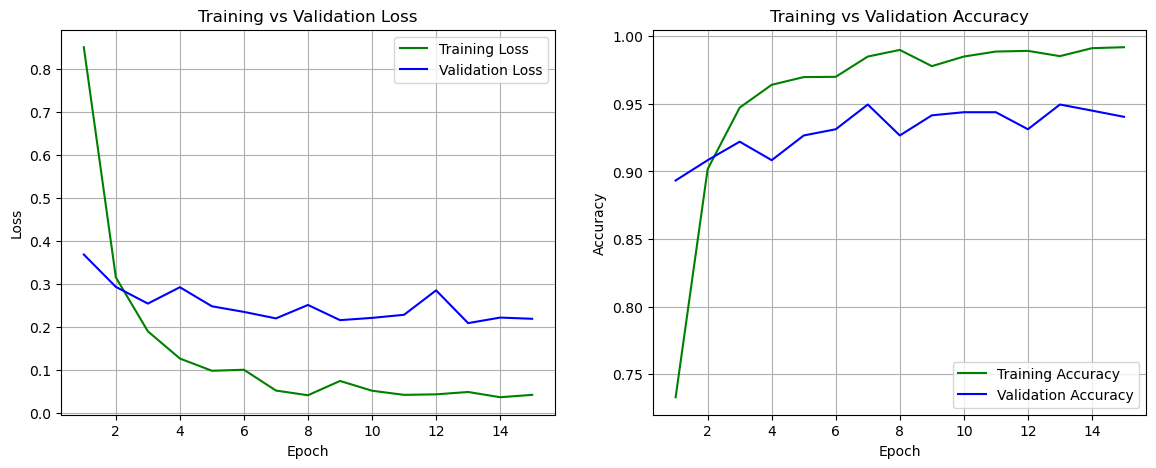

In [64]:
train_losses = [
    0.8513,0.3153,0.1896,0.1262,0.0977,
    0.1001,0.0516,0.0407,0.0740,0.0512,
    0.0416,0.0428,0.0483,0.0361,0.0416
]

val_losses = [
    0.3684,0.2931,0.2542,0.2923,0.2479,
    0.2348,0.2197,0.2510,0.2156,0.2209,
    0.2281,0.2850,0.2087,0.2216,0.2188
]

train_accuracies = [
    0.7329,0.9017,0.9472,0.9641,0.9698,
    0.9700,0.9850,0.9899,0.9779,0.9850,
    0.9887,0.9892,0.9853,0.9912,0.9919
]

val_accuracies = [
    0.8933,0.9083,0.9220,0.9083,0.9266,
    0.9312,0.9495,0.9266,0.9415,0.9438,
    0.9438,0.9312,0.9495,0.9450,0.9404
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# ===== Loss Plot =====
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='green')
plt.plot(epochs, val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ===== Accuracy Plot =====
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.show()


As the figure shows, the model learns quickly, with both accuracy and loss curves improving across the epochs. However, the validation trend begins to level off while the training curve continues to rise, indicating that the model is starting to overfit despite showing strong overall learning behavior.


Evaluation on Test Set (Accuracy + F1 + Confusion Matrix)

In [ ]:
import torch
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

best_model = model     
state_dict = torch.load("best_resnet18.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)


test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2723
Test Accuracy: 0.9347



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        85
           1       0.81      0.99      0.89        85
           2       1.00      0.98      0.99        63
           3       0.98      0.92      0.95        63
           4       0.98      0.97      0.98        65
           5       0.88      0.88      0.88        65
           6       0.89      0.99      0.94        68
           7       0.94      1.00      0.97        68
           8       0.99      0.91      0.94        85
           9       0.97      0.89      0.93        85
          10       0.99      0.97      0.98        72
          11       0.91      0.77      0.83        69

    accuracy                           0.93       873
   macro avg       0.94      0.93      0.94       873
weighted avg       0.94      0.93      0.93       873



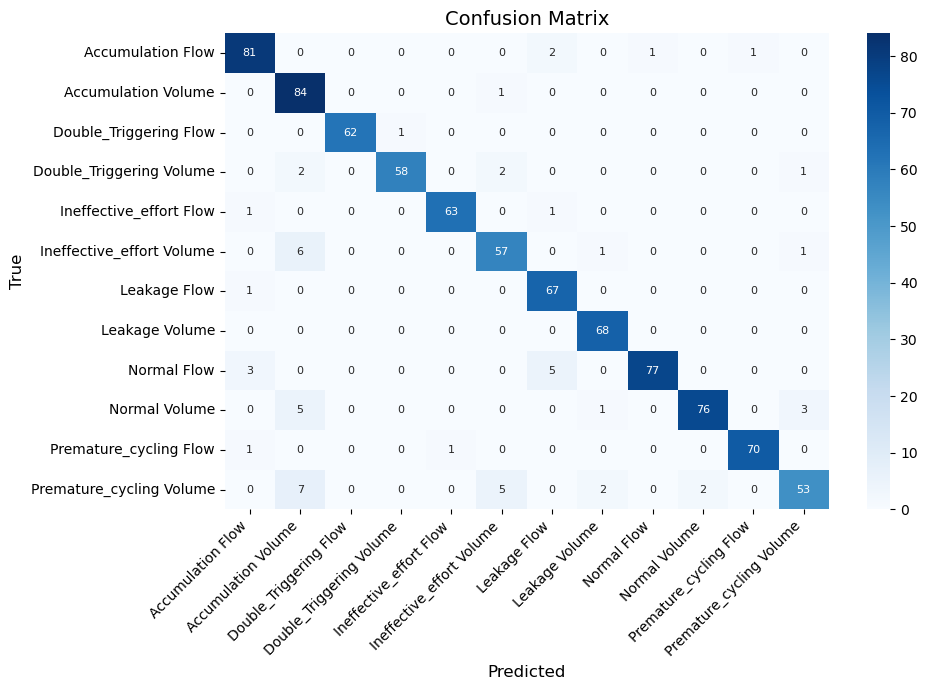

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("best_resnet18.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap="Blues",     
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    annot_kws={"size": 8}  
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Classification Report & Confusion Matrix Summary

The classification report shows strong results, with an overall F1-score of **0.93**, indicating that the model is performing very well across all waveform classes. The confusion matrix also shows a clear diagonal pattern, meaning most predictions are correct with only minor misclassifications.

**Conclusion:**  
The ResNet model shows clear signs of overfitting, as training performance continues to rise while validation performance stabilizes. However, despite this, the model still achieves strong generalization with a high F1-score of 0.93, making its predictions reliable on the test set.


## Model Comparison:
EfficientNet-B0 showed stable learning with Training Accuracy ≈ 0.68, Validation Accuracy ≈ 0.73, and an F1-score of ~0.72, without any signs of underfitting or overfitting. In contrast, ResNet reached a very high Training Accuracy ≈ 0.985 and Validation Accuracy ≈ 0.95 with an F1-score of 0.93, but the widening gap between training and validation indicates clear overfitting as validation performance plateaued.

**Final Decision:**  
EfficientNet-B0 was chosen as the final model because, unlike ResNet, it does not show any overfitting and provides stable, balanced performance. While ResNet achieved higher accuracy, EfficientNet offered safer and more reliable behavior, which fits the project’s goal of building a dependable model with acceptable and consistent results.
